## Import

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import chi2_contingency

color_map = {
    "date":                    "black",
    "Indicateur_moyen_Brut_1": "tab:blue",
    "Indicateur_moyen_Brut_2": "tab:orange",
    "Indicateur_moyen_Brut_3": "tab:green",
    "Indicateur_moyen_Brut_4": "tab:red",
    "Indicateur_moyen_Brut_5": "tab:purple",
    "Indicateur_moyen_Brut_6": "tab:brown",
    "Indicateur_Moyen_1_5":    "tab:pink",
    "Indicateur_Moyen_1_6":    "tab:gray",
    "PIB":                     "tab:olive",
    "IPL":                     "tab:cyan",
    "TCH":                     "black",
    "Inflation":               "gold",
    "PIB_diff1":               "navy",
    "IPL_diff1":               "teal",
    "TCH_diff1":               "maroon",
    "Inflation_diff1":         "lime"
}
ccf_et_macro = pd.read_excel(r"data\ccf_et_macro.xlsx").iloc[:,1:]

In [4]:
segment = pd.read_csv(r"data\brutes\Données_CCF_PAR_SEGMENT.csv",sep=";")
segment.head()

,cod_prd_ref,note_ref,Indicateur_moyen_Brut,PourcNote,PourcNoteCohorte,PourcNoteCohorte5
0,2009T1,1,"0,451962798","0,0128162511542013","0,0677866770853682","0,115244104948522"
1,2009T1,2,"0,9185154","0,0150016761649346","0,13987106856808","0,237794752573896"
2,2009T1,3,"0,919842763","0,0188878742730812","0,0767728071889041","0,130521421454666"
3,2009T1,4,"1,275863582","0,0148540805032912","0,0498144168782965","0,0846894719362338"
4,2009T1,5,"1,093202854","0,0221397186552676","0,2539558507521","0,431750249086682"


In [5]:
macro = pd.read_excel(r"data\brutes\historique_macro_variables_projet_CCF_FowardLooking_IFRS9.xlsx")
macro["date_dernier_mois"] = pd.to_datetime(macro["date_dernier_mois"], format="%Y-%m")
macro["cod_prd_ref"] = macro["date_dernier_mois"].dt.year.astype(str) + "T" + macro["date_dernier_mois"].dt.quarter.astype(str)
macro.drop(columns=["date_dernier_mois"], inplace=True)
macro = macro[macro["cod_prd_ref"] >= '2009T1']


In [6]:
macro.head()

,PIB,IPL,TCH,Inflation,PIB_diff1,IPL_diff1,TCH_diff1,Inflation_diff1,cod_prd_ref
116,-1.286788,-1.624415,8.3,0.301692,-1.430885,-2.593841,0.9,-0.697982,2009T1
117,-2.243102,-4.278729,8.8,-0.489570,-0.956314,-2.654313,0.5,-0.791262,2009T2
118,-3.012266,-6.103516,8.8,-0.362976,-0.769164,-1.824787,0.0,0.126594,2009T3
119,-2.782833,-6.105367,9.2,0.914470,0.229433,-0.001851,0.4,1.277447,2009T4
120,-1.517665,-4.278209,9.0,1.589859,1.265167,1.827158,-0.2,0.675389,2010T1


## Stationnarité

### Variable Macro

In [7]:
from statsmodels.tsa.stattools import adfuller

def tester_stationnarite_macro(df_macro, colonnes=None, verbose=True):
    """
    Teste la stationnarité (ADF) des colonnes d'un DataFrame macro.
    """
    if colonnes is None:
        colonnes = [col for col in df_macro.columns if col != "cod_prd_ref"]

    résultats = {}

    for col in colonnes:
        série = df_macro[col].dropna()
        try:
            adf_result = adfuller(série, regression='ct')  # regression='c' pour constante
            p_value = adf_result[1]
            résultats[col] = p_value
            if verbose:
                état = "✅ Stationnaire" if p_value < 0.05 else "❌ Non stationnaire"
                print(f"{col} : p-value = {p_value:.4f} → {état}")
        except Exception as e:
            résultats[col] = None
            print(f"{col} : ❌ Erreur lors du test ADF → {e}")

    return None
tester_stationnarite_macro(macro)


PIB : p-value = 0.0801 → ❌ Non stationnaire
IPL : p-value = 0.5321 → ❌ Non stationnaire
TCH : p-value = 0.6430 → ❌ Non stationnaire
Inflation : p-value = 0.7576 → ❌ Non stationnaire
PIB_diff1 : p-value = 0.0027 → ✅ Stationnaire
IPL_diff1 : p-value = 0.2559 → ❌ Non stationnaire
TCH_diff1 : p-value = 0.0000 → ✅ Stationnaire
Inflation_diff1 : p-value = 0.0051 → ✅ Stationnaire


In [8]:
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.filters.hp_filter import hpfilter
from scipy.stats import boxcox
import matplotlib.pyplot as plt

def tester_transformations_ipl(df, col="IPL_diff1"):
    série = df[col].dropna()
    résultats = {}

    # 1. ADF brut
    p_brute = adfuller(série, regression='ct')[1]
    résultats["Brute"] = p_brute

    # 2. Diff(2)
    try:
        diff2 = série.diff().dropna()
        résultats["Diff(2)"] = adfuller(diff2, regression='ct')[1]
    except:
        résultats["Diff(2)"] = None

    # 3. HP filter
    try:
        cycle, trend = hpfilter(série, lamb=1600)
        résultats["HP Cycle"] = adfuller(cycle.dropna(), regression='ct')[1]
    except:
        résultats["HP Cycle"] = None

    # 4. Log + Diff (si possible)
    try:
        if (série > 0).all():
            log_diff = np.log(série).diff().dropna()
            résultats["Log-Diff"] = adfuller(log_diff, regression='ct')[1]
        else:
            résultats["Log-Diff"] = None
    except:
        résultats["Log-Diff"] = None

    # 5. Box-Cox + Diff (si > 0)
    try:
        if (série > 0).all():
            bc_trans, _ = boxcox(série)
            bc_diff = pd.Series(bc_trans).diff().dropna()
            résultats["BoxCox-Diff"] = adfuller(bc_diff, regression='ct')[1]
        else:
            résultats["BoxCox-Diff"] = None
    except:
        résultats["BoxCox-Diff"] = None

    # Affichage des résultats
    print("\nRésultats ADF pour différentes transformations :")
    for k, p in résultats.items():
        if p is None:
            print(f"{k}: ❌ Erreur")
        else:
            état = "✅ Stationnaire" if p < 0.05 else "❌ Non stationnaire"
            print(f"{k}: p-value = {p:.4f} → {état}")

    return None
tester_transformations_ipl(macro)



Résultats ADF pour différentes transformations :
Brute: p-value = 0.2559 → ❌ Non stationnaire
Diff(2): p-value = 0.1891 → ❌ Non stationnaire
HP Cycle: p-value = 0.0035 → ✅ Stationnaire
Log-Diff: ❌ Erreur
BoxCox-Diff: ❌ Erreur


In [9]:
from statsmodels.tsa.filters.hp_filter import hpfilter

cycle_ipl, trend_ipl = hpfilter(macro["IPL_diff1"].dropna(), lamb=1600)
macro["IPL_diff1_hp"] = cycle_ipl


In [10]:
macro.head()

,PIB,IPL,TCH,Inflation,PIB_diff1,IPL_diff1,TCH_diff1,Inflation_diff1,cod_prd_ref,IPL_diff1_hp
116,-1.286788,-1.624415,8.3,0.301692,-1.430885,-2.593841,0.9,-0.697982,2009T1,-2.287187
117,-2.243102,-4.278729,8.8,-0.489570,-0.956314,-2.654313,0.5,-0.791262,2009T2,-2.418131
118,-3.012266,-6.103516,8.8,-0.362976,-0.769164,-1.824787,0.0,0.126594,2009T3,-1.657648
119,-2.782833,-6.105367,9.2,0.914470,0.229433,-0.001851,0.4,1.277447,2009T4,0.100615
120,-1.517665,-4.278209,9.0,1.589859,1.265167,1.827158,-0.2,0.675389,2010T1,1.873299


### Variable pas macro

In [11]:
segment.head()

,cod_prd_ref,note_ref,Indicateur_moyen_Brut,PourcNote,PourcNoteCohorte,PourcNoteCohorte5
0,2009T1,1,"0,451962798","0,0128162511542013","0,0677866770853682","0,115244104948522"
1,2009T1,2,"0,9185154","0,0150016761649346","0,13987106856808","0,237794752573896"
2,2009T1,3,"0,919842763","0,0188878742730812","0,0767728071889041","0,130521421454666"
3,2009T1,4,"1,275863582","0,0148540805032912","0,0498144168782965","0,0846894719362338"
4,2009T1,5,"1,093202854","0,0221397186552676","0,2539558507521","0,431750249086682"


In [12]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Tester la stationnarité de chaque segment (note_ref 1 à 5)
for i in range(1, 6):
    segment_i = segment[segment["note_ref"] == i].copy()

    # Conversion correcte des valeurs avec virgules en float
    try:
        series = segment_i["Indicateur_moyen_Brut"].str.replace(",", ".").astype(float).dropna()
    except Exception as e:
        print(f"\n❌ Erreur conversion Segment {i} : {e}")
        continue

    print(f"\n🔎 Test ADF - Segment {i}")
    try:
        result = adfuller(series,regression='ct')
        p_value = result[1]
        if p_value < 0.05:
            print(f"✅ Stationnaire (p-value = {p_value:.4f})")
        else:
            print(f"❌ Non stationnaire (p-value = {p_value:.4f})")
    except Exception as e:
        print(f"⚠️ Erreur ADF pour le segment {i} : {e}")



🔎 Test ADF - Segment 1
✅ Stationnaire (p-value = 0.0001)

🔎 Test ADF - Segment 2
❌ Non stationnaire (p-value = 0.4601)

🔎 Test ADF - Segment 3
❌ Non stationnaire (p-value = 1.0000)

🔎 Test ADF - Segment 4
✅ Stationnaire (p-value = 0.0000)

🔎 Test ADF - Segment 5
✅ Stationnaire (p-value = 0.0000)


In [13]:
from statsmodels.tsa.filters.hp_filter import hpfilter

# Liste des segments non stationnaires à transformer
segments_hp = [2, 3]

# Appliquer le HP filter et stocker le cycle dans une nouvelle colonne
for i in segments_hp:
    segment_i = segment[segment["note_ref"] == i].copy()

    try:
        series = segment_i["Indicateur_moyen_Brut"].str.replace(",", ".").astype(float).dropna()

        # HP filter
        cycle, trend = hpfilter(series, lamb=1600)
        segment.loc[segment["note_ref"] == i, "cycle_hp"] = cycle.values

        print(f"✅ HP filter appliqué au segment {i}")
    except Exception as e:
        print(f"❌ Erreur pour le segment {i} : {e}")


✅ HP filter appliqué au segment 2
✅ HP filter appliqué au segment 3


In [14]:
from statsmodels.tsa.stattools import adfuller

# Tester la stationnarité des cycles HP filtrés pour les segments 2 et 3
for i in [2, 3]:
    series_hp = segment.loc[segment["note_ref"] == i, "cycle_hp"].dropna()
    print(f"\n🔎 Test ADF sur cycle HP - Segment {i}")

    if len(series_hp) < 10:
        print("⚠️ Trop peu de données pour appliquer ADF")
        continue

    try:
        p_value = adfuller(series_hp, regression="ct")[1]
        état = "✅ Stationnaire" if p_value < 0.05 else "❌ Non stationnaire"
        print(f"p-value = {p_value:.4f} → {état}")
    except Exception as e:
        print(f"❌ Erreur ADF pour le segment {i} : {e}")



🔎 Test ADF sur cycle HP - Segment 2
p-value = 0.0429 → ✅ Stationnaire

🔎 Test ADF sur cycle HP - Segment 3
p-value = 0.0000 → ✅ Stationnaire


Mes series sont stationnaires mtn

### Merge des series

In [15]:
segment["cod_prd_ref"] = segment["cod_prd_ref"].astype(str).str.strip()
macro["cod_prd_ref"] = macro["cod_prd_ref"].astype(str).str.strip()

In [16]:
df_merged = pd.merge(segment, macro, on="cod_prd_ref", how="left")

In [17]:
df_merged["Indicateur_moyen_Brut"] = df_merged.apply(
    lambda row: row["cycle_hp"] if row["note_ref"] in [2, 3] else row["Indicateur_moyen_Brut"],
    axis=1
)


In [18]:
df_merged.columns

Index(['cod_prd_ref', 'note_ref', 'Indicateur_moyen_Brut', 'PourcNote',
       'PourcNoteCohorte', 'PourcNoteCohorte5', 'cycle_hp', 'PIB', 'IPL',
       'TCH', 'Inflation', 'PIB_diff1', 'IPL_diff1', 'TCH_diff1',
       'Inflation_diff1', 'IPL_diff1_hp'],
      dtype='object')

In [19]:
colonnes_a_supprimer = ['cycle_hp', 'PIB_diff1','IPL', 'TCH', 'Inflation', 'IPL_diff1']
df = df_merged.drop(columns=colonnes_a_supprimer)
df.columns

Index(['cod_prd_ref', 'note_ref', 'Indicateur_moyen_Brut', 'PourcNote',
       'PourcNoteCohorte', 'PourcNoteCohorte5', 'PIB', 'TCH_diff1',
       'Inflation_diff1', 'IPL_diff1_hp'],
      dtype='object')

In [20]:
segment_1 =df[df["note_ref"] == 1].copy()
segment_2 =df[df["note_ref"] == 2].copy()
segment_3 =df[df["note_ref"] == 3].copy()
segment_4 =df[df["note_ref"] == 4].copy()
segment_5 =df[df["note_ref"] == 5].copy()

In [21]:
segment_1.columns

Index(['cod_prd_ref', 'note_ref', 'Indicateur_moyen_Brut', 'PourcNote',
       'PourcNoteCohorte', 'PourcNoteCohorte5', 'PIB', 'TCH_diff1',
       'Inflation_diff1', 'IPL_diff1_hp'],
      dtype='object')

In [22]:
segment_1.shape

(60, 10)

In [23]:
segment_1.head()

,cod_prd_ref,note_ref,Indicateur_moyen_Brut,PourcNote,PourcNoteCohorte,PourcNoteCohorte5,PIB,TCH_diff1,Inflation_diff1,IPL_diff1_hp
0,2009T1,1,"0,451962798","0,0128162511542013","0,0677866770853682","0,115244104948522",-1.286788,0.9,-0.697982,-2.287187
6,2009T2,1,"0,59879537","0,0130378578024007","0,0655646359583952","0,109355638166047",-2.243102,0.5,-0.791262,-2.418131
12,2009T3,1,"0,460211701","0,0135918744228994","0,0593644136150992","0,100491534680502",-3.012266,0.0,0.126594,-1.657648
18,2009T4,1,"0,431517918","0,014145891043398","0,0610650510204082","0,102461209202782",-2.782833,0.4,1.277447,0.100615
24,2010T1,1,"0,302710264","0,0141828254847645","0,0634186622625929","0,10968294772922",-1.517665,-0.2,0.675389,1.873299


## Correlation

In [24]:
def enrichir_segment_v2(df):
    # --- Variables macro déjà transformées ---
    df["PIB_lag1"] = df["PIB"].shift(1)
    df["TCH_diff1_lag1"] = df["TCH_diff1"].shift(1)
    df["Inflation_diff1_lag1"] = df["Inflation_diff1"].shift(1)
    df["IPL_diff1_hp_lag1"] = df["IPL_diff1_hp"].shift(1)

    df["PIB_squared"] = df["PIB"] ** 2
    df["TCH_diff1_squared"] = df["TCH_diff1"] ** 2
    df["Inflation_diff1_squared"] = df["Inflation_diff1"] ** 2
    df["IPL_diff1_hp_squared"] = df["IPL_diff1_hp"] ** 2

    df["PIB_x_TCH"] = df["PIB"] * df["TCH_diff1"]
    df["PIB_x_Inflation"] = df["PIB"] * df["Inflation_diff1"]
    df["TCH_x_IPL"] = df["TCH_diff1"] * df["IPL_diff1_hp"]
    df["Inflation_x_IPL"] = df["Inflation_diff1"] * df["IPL_diff1_hp"]

    df["PIB_ma3"] = df["PIB"].rolling(window=3).mean()
    df["TCH_ma3"] = df["TCH_diff1"].rolling(window=3).mean()
    df["Inflation_ma3"] = df["Inflation_diff1"].rolling(window=3).mean()
    df["IPL_ma3"] = df["IPL_diff1_hp"].rolling(window=3).mean()

    # --- Affichage diagnostic ---
    print("Nombre de lignes avant enrichissement :", len(df))
    print("Nombre de lignes après enrichissement sans dropna :", df.shape[0])
    print("Nombre de NaN par colonne :")
    print(df.isna().sum())

    # --- Suppression uniquement si vraiment nécessaire ---
    colonnes_critiques = [
        "Indicateur_moyen_Brut", "PIB", "TCH_diff1", "Inflation_diff1", "IPL_diff1_hp",
        "PIB_lag1", "TCH_diff1_lag1", "Inflation_diff1_lag1", "IPL_diff1_hp_lag1",
        "PIB_ma3", "TCH_ma3", "Inflation_ma3", "IPL_ma3"
    ]
    df = df.dropna(subset=colonnes_critiques)

    return df


In [25]:
segment_1 = enrichir_segment_v2(segment_1)
segment_2 = enrichir_segment_v2(segment_2)
segment_3 = enrichir_segment_v2(segment_3)
segment_4 = enrichir_segment_v2(segment_4)
segment_5 = enrichir_segment_v2(segment_5)


Nombre de lignes avant enrichissement : 60
Nombre de lignes après enrichissement sans dropna : 60
Nombre de NaN par colonne :
cod_prd_ref                0
note_ref                   0
Indicateur_moyen_Brut      0
PourcNote                  0
PourcNoteCohorte           0
PourcNoteCohorte5          0
PIB                        0
TCH_diff1                  0
Inflation_diff1            0
IPL_diff1_hp               0
PIB_lag1                   1
TCH_diff1_lag1             1
Inflation_diff1_lag1       1
IPL_diff1_hp_lag1          1
PIB_squared                0
TCH_diff1_squared          0
Inflation_diff1_squared    0
IPL_diff1_hp_squared       0
PIB_x_TCH                  0
PIB_x_Inflation            0
TCH_x_IPL                  0
Inflation_x_IPL            0
PIB_ma3                    2
TCH_ma3                    2
Inflation_ma3              2
IPL_ma3                    2
dtype: int64
Nombre de lignes avant enrichissement : 60
Nombre de lignes après enrichissement sans dropna : 60
Nombre de

In [26]:
segment_1.head()

,cod_prd_ref,note_ref,Indicateur_moyen_Brut,PourcNote,PourcNoteCohorte,PourcNoteCohorte5,PIB,TCH_diff1,Inflation_diff1,IPL_diff1_hp,...,Inflation_diff1_squared,IPL_diff1_hp_squared,PIB_x_TCH,PIB_x_Inflation,TCH_x_IPL,Inflation_x_IPL,PIB_ma3,TCH_ma3,Inflation_ma3,IPL_ma3
12,2009T3,1,"0,460211701","0,0135918744228994","0,0593644136150992","0,100491534680502",-3.012266,0.0,0.126594,-1.657648,...,0.016026,2.747798,-0.000000,-0.381334,-0.000000,-0.209848,-2.180718,0.466667,-0.454217,-2.120989
18,2009T4,1,"0,431517918","0,014145891043398","0,0610650510204082","0,102461209202782",-2.782833,0.4,1.277447,0.100615,...,1.631870,0.010123,-1.113133,-3.554920,0.040246,0.128530,-2.679400,0.300000,0.204260,-1.325055
24,2010T1,1,"0,302710264","0,0141828254847645","0,0634186622625929","0,10968294772922",-1.517665,-0.2,0.675389,1.873299,...,0.456150,3.509248,0.303533,-1.025015,-0.374660,1.265206,-2.437588,0.066667,0.693143,0.105422
30,2010T2,1,"0,431341048","0,0148845798707295","0,0674138507862161","0,119089834515366",-0.263588,-0.1,-0.081838,3.130860,...,0.006697,9.802282,0.026359,0.021571,-0.313086,-0.256223,-1.521362,0.033333,0.623666,1.701591
36,2010T3,1,"0,489685502","0,0168421052631579","0,0778555574526208","0,140394088669951",1.092998,0.0,0.056320,3.202525,...,0.003172,10.256164,0.000000,0.061558,0.000000,0.180367,-0.229418,-0.100000,0.216624,2.735561


In [27]:
def corr_cible_vs_features(df, cible="Indicateur_moyen_Brut", seuil=0.2):
    """
    Affiche les corrélations entre la variable cible et toutes les autres variables numériques du DataFrame.
    """
    corr = df.corr(numeric_only=True)
    if cible not in corr.columns:
        print(f"⚠️ La cible '{cible}' n'existe pas dans ce DataFrame.")
        return None

    corrs = corr[cible].drop(cible).sort_values(key=abs, ascending=False)
    print(f"\n🔍 Corrélations avec {cible} (|ρ| > {seuil}):\n")
    print(corrs[abs(corrs) > seuil])
    return corrs


In [28]:
segments = {
    1: segment_1,
    2: segment_2,
    3: segment_3,
    4: segment_4,
    5: segment_5
}

for i in segments:
    try:
        segments[i]["Indicateur_moyen_Brut"] = (
            segments[i]["Indicateur_moyen_Brut"]
            .astype(str)
            .str.replace(",", ".", regex=False)
            .astype(float)
        )
        print(f"✅ Segment {i} : conversion OK")
    except Exception as e:
        print(f"❌ Segment {i} : erreur de conversion → {e}")


✅ Segment 1 : conversion OK
✅ Segment 2 : conversion OK
✅ Segment 3 : conversion OK
✅ Segment 4 : conversion OK
✅ Segment 5 : conversion OK


In [29]:
print("=== Segment 1 ===")
corrs_seg1 = corr_cible_vs_features(segment_1)

print("=== Segment 2 ===")
corrs_seg2 = corr_cible_vs_features(segment_2)

print("=== Segment 3 ===")
corrs_seg3 = corr_cible_vs_features(segment_3)

print("=== Segment 4 ===")
corrs_seg4 = corr_cible_vs_features(segment_4)

print("=== Segment 5 ===")
corrs_seg5 = corr_cible_vs_features(segment_5)


=== Segment 1 ===

🔍 Corrélations avec Indicateur_moyen_Brut (|ρ| > 0.2):

IPL_diff1_hp_squared    0.405836
PIB_squared            -0.349953
IPL_diff1_hp            0.240371
Name: Indicateur_moyen_Brut, dtype: float64
=== Segment 2 ===

🔍 Corrélations avec Indicateur_moyen_Brut (|ρ| > 0.2):

PIB_lag1           0.475575
PIB_ma3            0.472381
TCH_diff1_lag1    -0.318239
PIB                0.303069
PIB_squared       -0.286878
TCH_diff1          0.238095
Inflation_diff1   -0.236589
Inflation_x_IPL    0.206842
Name: Indicateur_moyen_Brut, dtype: float64
=== Segment 3 ===

🔍 Corrélations avec Indicateur_moyen_Brut (|ρ| > 0.2):

Inflation_diff1_squared    0.250900
PIB_x_Inflation            0.228991
PIB_lag1                   0.222477
PIB_ma3                    0.202450
Name: Indicateur_moyen_Brut, dtype: float64
=== Segment 4 ===

🔍 Corrélations avec Indicateur_moyen_Brut (|ρ| > 0.2):

TCH_ma3                 0.393065
IPL_diff1_hp_squared    0.392674
IPL_diff1_hp            0.310561
In

### Test poour tous les segments

In [30]:
def top_features_corr(df, cible="Indicateur_moyen_Brut", top_n=3):
    corr = df.corr(numeric_only=True)
    if cible not in corr.columns:
        print(f"⚠️ {cible} non trouvée.")
        return []
    corrs = corr[cible].drop(cible).abs().sort_values(ascending=False)
    return corrs.head(top_n).index.tolist()


In [31]:
import statsmodels.api as sm

def run_ols_top_features(df, cible="Indicateur_moyen_Brut"):
    top_features = top_features_corr(df, cible)
    X = df[top_features]
    y = df[cible]

    X = sm.add_constant(X)  # Ajout de l'intercept
    model = sm.OLS(y, X).fit()
    
    print(f"📊 Régression avec {top_features}")
    print(model.summary())
    return model


In [32]:
print("=== Segment 1 ===")
model_1 = run_ols_top_features(segment_1)

print("\n=== Segment 2 ===")
model_2 = run_ols_top_features(segment_2)

print("\n=== Segment 3 ===")
model_3 = run_ols_top_features(segment_3)

print("\n=== Segment 4 ===")
model_4 = run_ols_top_features(segment_4)

print("\n=== Segment 5 ===")
model_5 = run_ols_top_features(segment_5)


=== Segment 1 ===
📊 Régression avec ['IPL_diff1_hp_squared', 'PIB_squared', 'IPL_diff1_hp']
                              OLS Regression Results                             
Dep. Variable:     Indicateur_moyen_Brut   R-squared:                       0.259
Model:                               OLS   Adj. R-squared:                  0.218
Method:                    Least Squares   F-statistic:                     6.290
Date:                   Sat, 24 May 2025   Prob (F-statistic):           0.000971
Time:                           15:33:02   Log-Likelihood:                 59.211
No. Observations:                     58   AIC:                            -110.4
Df Residuals:                         54   BIC:                            -102.2
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]

In [33]:
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import shapiro, jarque_bera

def verifier_conditions_mco(model):
    print("\n🔎 Vérification des conditions MCO")

    # 1. Indépendance des résidus : Durbin-Watson
    dw = durbin_watson(model.resid)
    print(f"Durbin-Watson = {dw:.3f} → {'✅' if 1.5 <= dw <= 2.5 else '❌'} (entre 1.5 et 2.5 recommandé)")

    # 2. Homoscédasticité : Breusch-Pagan
    bp_test = het_breuschpagan(model.resid, model.model.exog)
    p_bp = bp_test[1]
    print(f"Breusch-Pagan p-value = {p_bp:.4f} → {'✅' if p_bp > 0.05 else '❌'} (H0: homoscédasticité)")

    # 3. Normalité des résidus : Shapiro-Wilk + Jarque-Bera
    p_shap = shapiro(model.resid)[1]
    p_jb = jarque_bera(model.resid)[1]
    print(f"Shapiro-Wilk p = {p_shap:.4f} → {'✅' if p_shap > 0.05 else '❌'} (H0: normalité)")
    print(f"Jarque-Bera  p = {p_jb:.4f} → {'✅' if p_jb > 0.05 else '❌'} (H0: normalité)")


In [34]:
print("=== Segment 1 ===")
verifier_conditions_mco(model_1)

print("\n=== Segment 2 ===")
verifier_conditions_mco(model_2)

print("\n=== Segment 3 ===")
verifier_conditions_mco(model_3)

print("\n=== Segment 4 ===")
verifier_conditions_mco(model_4)

print("\n=== Segment 5 ===")
verifier_conditions_mco(model_5)


=== Segment 1 ===

🔎 Vérification des conditions MCO
Durbin-Watson = 1.186 → ❌ (entre 1.5 et 2.5 recommandé)
Breusch-Pagan p-value = 0.3021 → ✅ (H0: homoscédasticité)
Shapiro-Wilk p = 0.1344 → ✅ (H0: normalité)
Jarque-Bera  p = 0.3959 → ✅ (H0: normalité)

=== Segment 2 ===

🔎 Vérification des conditions MCO
Durbin-Watson = 1.735 → ✅ (entre 1.5 et 2.5 recommandé)
Breusch-Pagan p-value = 0.8240 → ✅ (H0: homoscédasticité)
Shapiro-Wilk p = 0.6829 → ✅ (H0: normalité)
Jarque-Bera  p = 0.5962 → ✅ (H0: normalité)

=== Segment 3 ===

🔎 Vérification des conditions MCO
Durbin-Watson = 2.154 → ✅ (entre 1.5 et 2.5 recommandé)
Breusch-Pagan p-value = 0.5060 → ✅ (H0: homoscédasticité)
Shapiro-Wilk p = 0.6380 → ✅ (H0: normalité)
Jarque-Bera  p = 0.6450 → ✅ (H0: normalité)

=== Segment 4 ===

🔎 Vérification des conditions MCO
Durbin-Watson = 1.490 → ❌ (entre 1.5 et 2.5 recommandé)
Breusch-Pagan p-value = 0.7550 → ✅ (H0: homoscédasticité)
Shapiro-Wilk p = 0.9884 → ✅ (H0: normalité)
Jarque-Bera  p = 0.95

In [35]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import shapiro, jarque_bera
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# === 1. Fonction d'enrichissement macro ===
def add_macro_lags_and_interactions(df):
    df = df.copy()

    for col in ["PIB", "TCH_diff1", "Inflation_diff1", "IPL_diff1_hp"]:
        df[f"{col}_lag2"] = df[col].shift(2)
        df[f"{col}_ma5"] = df[col].rolling(5).mean()

    df["PIB_x_TCH_ma3"] = df["PIB"] * df["TCH_diff1"].rolling(3).mean()
    df["TCH_diff1_squared"] = df["TCH_diff1"] ** 2

    return df.dropna()

# === 2. OLS + diagnostics MCO ===
def evaluate_ols_with_diagnostics(X, y):
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    diagnostics = {
        "R2": model.rsquared,
        "Adj_R2": model.rsquared_adj,
        "DW": durbin_watson(model.resid),
        "BP_p": het_breuschpagan(model.resid, X)[1],
        "Shapiro_p": shapiro(model.resid)[1],
        "JB_p": jarque_bera(model.resid)[1]
    }
    return model, diagnostics

# === 3. Ridge et Random Forest ===
def train_alt_models(X, y):
    X = X.fillna(0)
    ridge = RidgeCV(alphas=np.logspace(-3, 3, 20)).fit(X, y)
    rf = RandomForestRegressor(n_estimators=100, random_state=42).fit(X, y)
    return {
        "R2_ridge": r2_score(y, ridge.predict(X)),
        "R2_rf": r2_score(y, rf.predict(X))
    }

# === 4. Boucle sur les segments ===
segments = {
    1: segment_1.copy(),
    2: segment_2.copy(),
    3: segment_3.copy(),
    4: segment_4.copy(),
    5: segment_5.copy()
}

results_summary = []

for i, df in segments.items():
    # CIBLE
    y = df["Indicateur_moyen_Brut"]

    # === Base ===
    X_base = df.drop(columns=["cod_prd_ref", "note_ref", "Indicateur_moyen_Brut"])
    X_base = X_base.select_dtypes(include=[np.number]).astype(float).dropna()
    y_base = y.loc[X_base.index]

    model_base, diag_base = evaluate_ols_with_diagnostics(X_base, y_base)

    # === Enrichi ===
    df_enriched = add_macro_lags_and_interactions(df)
    y_enriched = df_enriched["Indicateur_moyen_Brut"]

    X_enriched = df_enriched.drop(columns=["cod_prd_ref", "note_ref", "Indicateur_moyen_Brut"])
    X_enriched = X_enriched.select_dtypes(include=[np.number]).astype(float).dropna()
    y_enriched = y_enriched.loc[X_enriched.index]

    model_enriched, diag_enriched = evaluate_ols_with_diagnostics(X_enriched, y_enriched)
    alt_models = train_alt_models(X_enriched, y_enriched)

    results_summary.append({
        "Segment": i,
        "R2_base": diag_base["R2"],
        "R2_enriched": diag_enriched["R2"],
        "R2_ridge": alt_models["R2_ridge"],
        "R2_rf": alt_models["R2_rf"],
        "DW": diag_enriched["DW"],
        "BP_p": diag_enriched["BP_p"],
        "Shapiro_p": diag_enriched["Shapiro_p"],
        "JB_p": diag_enriched["JB_p"]
    })

# === Résumé final
results_df = pd.DataFrame(results_summary)
print("\n📊 Résumé comparatif des performances et diagnostics MCO :")
display(results_df.round(3))



📊 Résumé comparatif des performances et diagnostics MCO :


,Segment,R2_base,R2_enriched,R2_ridge,R2_rf,DW,BP_p,Shapiro_p,JB_p
0,1,0.597,0.731,0.413,0.889,1.970,0.702,0.340,0.523
1,2,0.559,0.607,0.493,0.895,2.385,0.993,0.116,0.101
2,3,0.437,0.568,0.081,0.860,2.124,0.869,0.121,0.256
3,4,0.663,0.706,0.251,0.894,2.190,0.955,0.124,0.789
4,5,0.472,0.573,0.147,0.889,1.866,1.000,0.000,0.000


In [36]:
def choisir_meilleur_modele(results_df, seuil_dw=(1.5, 2.5), seuil_p=0.05):
    modèles = []
    for _, row in results_df.iterrows():
        segment = row["Segment"]
        
        # Sélection du meilleur modèle basé sur R²
        if row["R2_rf"] >= row["R2_enriched"] and row["R2_rf"] >= row["R2_ridge"]:
            best = "Random Forest"
        elif row["R2_enriched"] >= row["R2_ridge"]:
            best = "OLS enrichi"
        else:
            best = "Ridge"

        # Analyse MCO
        raisons = []
        if not (seuil_dw[0] <= row["DW"] <= seuil_dw[1]):
            raisons.append(f"DW={row['DW']:.2f} hors [{seuil_dw[0]}, {seuil_dw[1]}]")
        if row["BP_p"] <= seuil_p:
            raisons.append(f"BP_p={row['BP_p']:.3f} ≤ {seuil_p}")
        if row["Shapiro_p"] <= seuil_p:
            raisons.append(f"Shapiro_p={row['Shapiro_p']:.3f} ≤ {seuil_p}")
        if row["JB_p"] <= seuil_p:
            raisons.append(f"JB_p={row['JB_p']:.3f} ≤ {seuil_p}")
        
        if raisons:
            mco_ok = "❌"
            detail = " / ".join(raisons)
        else:
            mco_ok = "✅"
            detail = ""

        modèles.append({
            "Segment": segment,
            "Modèle_retenu": best,
            "MCO_OK": mco_ok,
            "Detail_MCO": detail
        })

    return pd.DataFrame(modèles)
meilleurs_modèles_df = choisir_meilleur_modele(results_df)
display(meilleurs_modèles_df)


,Segment,Modèle_retenu,MCO_OK,Detail_MCO
0,1.0,Random Forest,✅,
1,2.0,Random Forest,✅,
2,3.0,Random Forest,✅,
3,4.0,Random Forest,✅,
4,5.0,Random Forest,❌,Shapiro_p=0.000 ≤ 0.05 / JB_p=0.000 ≤ 0.05


Durbin-Watson (DW) : détecte l’autocorrélation des résidus. Valeur idéale proche de 2.

Breusch-Pagan (BP_p) : teste l’homoscédasticité (variance constante des erreurs). H₀ : variance constante (p > 0.05).

Shapiro-Wilk et Jarque-Bera (Shapiro_p, JB_p) : testent la normalité des résidus. H₀ : résidus ~ Normale (p > 0.05).

In [37]:

predictions_by_segment = {}

for i in range(1, 6):
    df = segments[i]
    model_name = meilleurs_modèles_df.loc[meilleurs_modèles_df["Segment"] == i, "Modèle_retenu"].values[0]
    
    # Enrichir les features
    df_enriched = add_macro_lags_and_interactions(df)
    X = df_enriched.drop(columns=["cod_prd_ref", "note_ref", "Indicateur_moyen_Brut"])
    y = df_enriched["Indicateur_moyen_Brut"]
    X = X.select_dtypes(include=[np.number]).astype(float).dropna()
    y = y.loc[X.index]

    # Modèle
    if model_name == "OLS enrichi":
        X_ols = sm.add_constant(X)
        model = sm.OLS(y, X_ols).fit()
        y_pred = model.predict(X_ols)
    elif model_name == "Ridge":
        model = RidgeCV(alphas=np.logspace(-3, 3, 20)).fit(X, y)
        y_pred = model.predict(X)
    else:  # Random Forest
        model = RandomForestRegressor(n_estimators=100, random_state=42).fit(X, y)
        y_pred = model.predict(X)

    df_result = df_enriched.loc[X.index].copy()
    df_result["prediction"] = y_pred
    predictions_by_segment[i] = df_result

    print(f"✅ Segment {i} – modèle {model_name} – R² = {r2_score(y, y_pred):.3f}")


✅ Segment 1 – modèle Random Forest – R² = 0.889


✅ Segment 2 – modèle Random Forest – R² = 0.895
✅ Segment 3 – modèle Random Forest – R² = 0.860
✅ Segment 4 – modèle Random Forest – R² = 0.894
✅ Segment 5 – modèle Random Forest – R² = 0.889


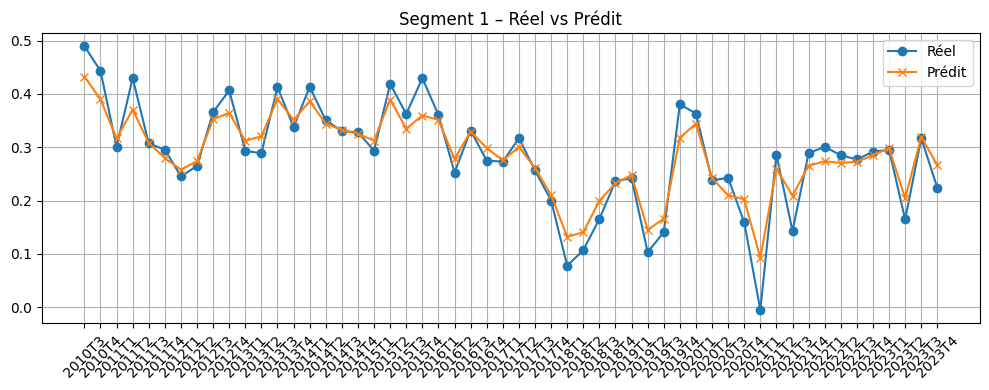

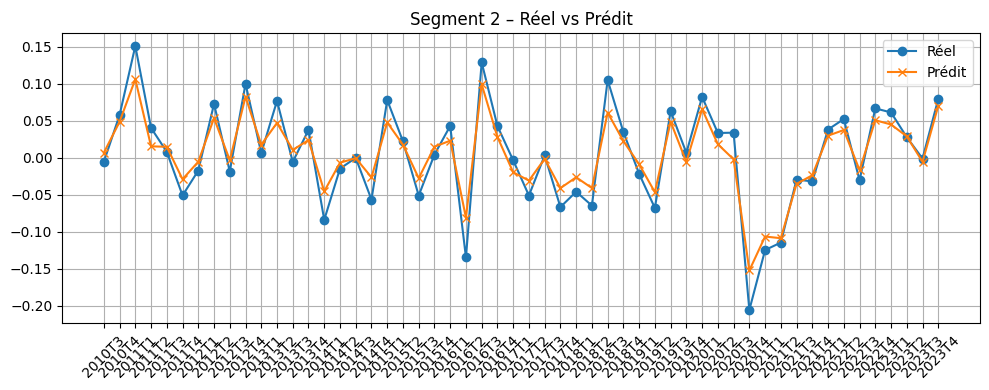

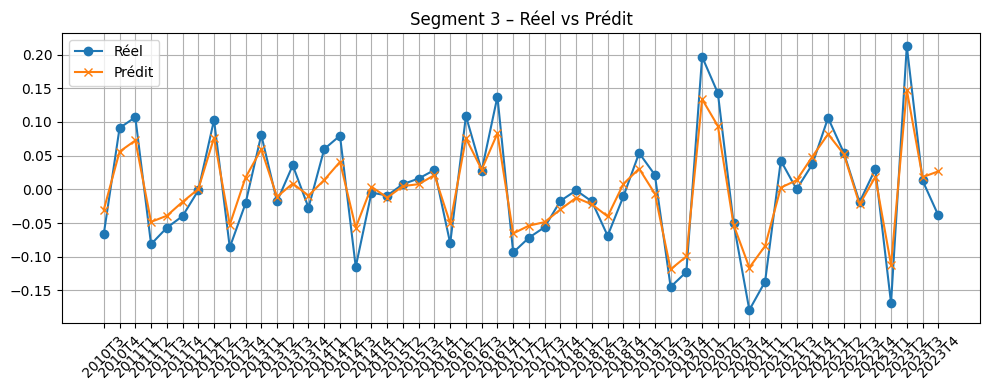

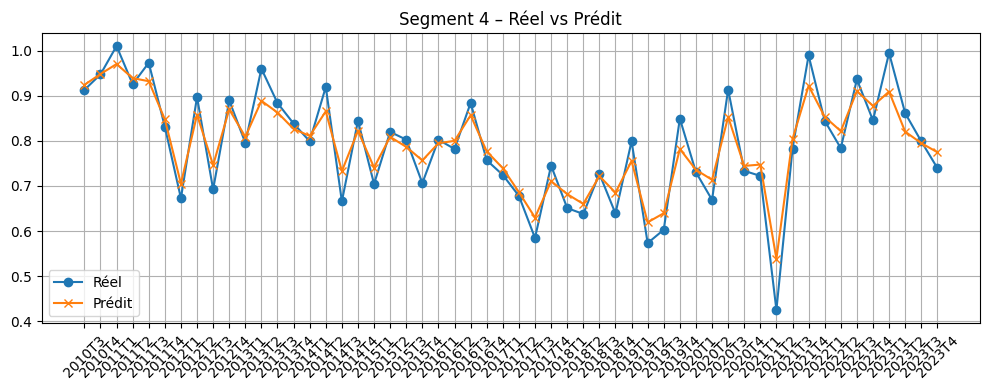

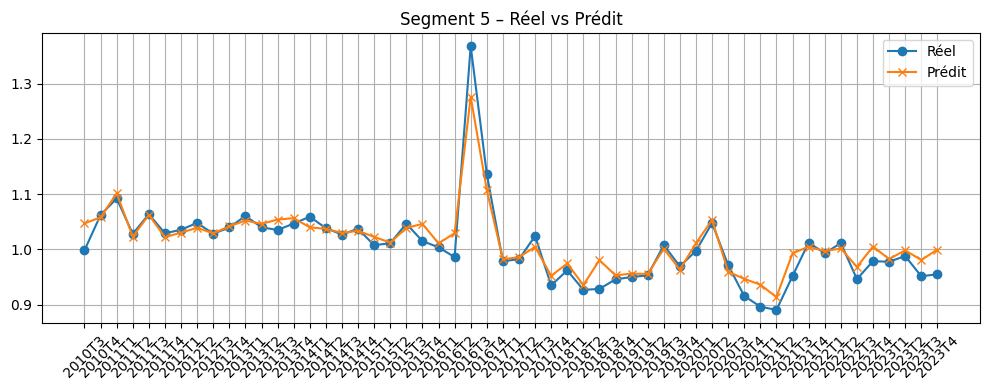

In [38]:
import matplotlib.pyplot as plt

for i, df_pred in predictions_by_segment.items():
    plt.figure(figsize=(10, 4))
    plt.plot(df_pred["cod_prd_ref"], df_pred["Indicateur_moyen_Brut"], label="Réel", marker='o')
    plt.plot(df_pred["cod_prd_ref"], df_pred["prediction"], label="Prédit", marker='x')
    plt.title(f"Segment {i} – Réel vs Prédit")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()


# Scenario

In [41]:
scenario = pd.read_excel(r"data\Scenario_horizon3ans_propre.xlsx")

In [43]:
# df_T1 = pd.read_excel(r"C:\Users\chemm\OneDrive\Bureau\cours\MOSEF\Risque de credit\Test\dictionnaire\Scenario_input_construction.xlsx", sheet_name='T1')
# df_T2 = pd.read_excel(r"C:\Users\chemm\OneDrive\Bureau\cours\MOSEF\Risque de credit\Test\dictionnaire\Scenario_input_construction.xlsx", sheet_name='T2')
# df_T3 = pd.read_excel(r"C:\Users\chemm\OneDrive\Bureau\cours\MOSEF\Risque de credit\Test\dictionnaire\Scenario_input_construction.xlsx", sheet_name='T3')   
# df_T4 = pd.read_excel(r"C:\Users\chemm\OneDrive\Bureau\cours\MOSEF\Risque de credit\Test\dictionnaire\Scenario_input_construction.xlsx", sheet_name='T4')

In [44]:
scenario.head()

,date,PIB_PESS,PIB_CENT,PIB_OPT,IPL_PESS,IPL_CENT,IPL_OPT,TCH_PESS,TCH_CENT,TCH_OPT,Inflation_PESS,Inflation_CENT,Inflation_OPT
0,2024-01-01,-0.6000,0.4000,1.50,-3.0,1.00,3.0,7.9700,7.62,7.200,7.0,1.70,0.0000
1,2024-04-01,-0.3875,0.5375,1.57,-3.5,1.25,3.5,8.0375,7.64,7.075,6.5,1.72,0.1625
2,2024-07-01,-0.1750,0.6750,1.64,-4.0,1.50,4.0,8.1050,7.66,6.950,6.0,1.74,0.3250
3,2024-10-01,0.0375,0.8125,1.71,-4.5,1.75,4.5,8.1725,7.68,6.825,5.5,1.76,0.4875
4,2025-01-01,0.2500,0.9500,1.78,-5.0,2.00,5.0,8.2400,7.70,6.700,5.0,1.78,0.6500


## Scenario 1